 # PyFD for Bike Rental Predictions
 ## Setup
 This second tutorial introduces how to use the `PyFD` package on a Gradient Boosted Tree (GBT) model trained
 to predict the number of bike rentals given time and weather features. We will see how to
 interpret said model in spite of the presence of strong feature interactions.

In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import KFold, RandomizedSearchCV, train_test_split
from sklearn.metrics import root_mean_squared_error
from joblib import dump, load

# Local imports
from pyfd.data import get_data_bike

 ## Input Features
 First load the data and a `Features` object that stores
 information about the various features. Note that the data **X** must **always**
 be a numerical numpy array. Categorical features are assumed to have been ordinally encoded.

In [9]:
# Built-in function for the BikeSharing dataset
X, y, features = get_data_bike()
# Make months and weekdays smaller for the plots (optional)
features.feature_objs[1].cats = ["J", "F", "M", "A", "M", "J", "J", "A", "S", "O", "N", "D"]
features.feature_objs[4].cats = ["M", "T", "W", "T", "F", "S", "S"]
features.summary()

|Idx|        Name        |        Type        |    Card    |      Groups      |
-------------------------------------------------------------------------------
| 0 | yr                 | ordinal            | 2          | [0]              |
| 1 | mnth               | ordinal            | 12         | [1]              |
| 2 | hr                 | num_int            | 24         | [2]              |
| 3 | holiday            | bool               | 2          | [3]              |
| 4 | weekday            | ordinal            | 7          | [4]              |
| 5 | workingday         | bool               | 2          | [5]              |
| 6 | weathersit         | num_int            | 4          | [6]              |
| 7 | temp               | num                | inf        | [7]              |
| 8 | hum                | num                | inf        | [8]              |
| 9 | windspeed          | num                | inf        | [9]              |
----------------------------------------

 This dataset involves 10 features of various types. The following Table can help understand their meaning and domain.

<img src="./Images/Features_bike.png" width="600">

 ## Fitting the model
 Having fetched the data, we fit a `HistGradientBoostingRegressor`.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = HistGradientBoostingRegressor(random_state=0)

**Do not run the following cells if you have already trained the model. Skip to later cells.**

In [ ]:
grid = {"learning_rate": np.logspace(-2, 0, 10),
        "max_depth" : [3, 4, 5, 6, 7],
        "max_iter" : [50, 100, 150, 200],
        'min_samples_leaf' : [1, 20, 40, 60, 80, 100]}

search = RandomizedSearchCV(
    model,
    cv=KFold(),
    scoring='neg_root_mean_squared_error',
    param_distributions=grid,
    verbose=2,
    n_iter=20,
    random_state=42
)
search.fit(X_train, y_train)

In [ ]:
# Recover the optimal CV model
model = search.best_estimator_
res = search.cv_results_
cv_perf = np.nan_to_num(-res['mean_test_score'], nan=1e10)
best_idx = np.argmin(cv_perf)

In [ ]:
plt.figure(figsize=(4, 4))
plt.scatter(res['param_learning_rate'], cv_perf, c='b', alpha=0.75)
plt.plot(res['param_learning_rate'][best_idx], cv_perf[best_idx], 'r*', markersize=10, markeredgecolor='k')
plt.xlabel("Learning Rate")
plt.ylabel("Cross-Validated RMSE")
plt.xscale('log')

In [ ]:
# Pickle the model
dump(model, os.path.join("models", "bike_gbt.joblib"))

**Start from here if you have already trained and dumped the model.**

In [11]:
# Load the model
model = load(os.path.join("models", "bike_gbt.joblib"))
test_preds = model.predict(X_test)
print(f" RMSE of the model : {root_mean_squared_error(test_preds, y_test):.2f}")
print(f" Std dev of the target : {y_test.std():.2f}")

 RMSE of the model : 43.08
 Std dev of the target : 181.45


 ## Computing Additive Explanations
 This models appears to make accurate predictions of bike rentals.
 But do you trust it? The issue it that the model $h$ is a black-box and
 we do not (yet) understand the mechanisms happening inside. To get
 more insight on our model, we are going to compute a functional decomposition
 
 $$h(x) = \sum_{u\subseteq [d]}h_u(x_u),$$
 
 where $[d]:= \{1, 2, \ldots, d\}$ and the function $h_u$ only depends on the subvector $x_u$.
 Let's visualize the additive terms $h_i$ of the decomposition which only depend on feature $x_i$.

In [ ]:
from pyfd.decompositions import get_components_tree
# Compute the h_1, h_2, ..., terms of the Functional Decomposition
background = X_train[:1000]
decomposition = get_components_tree(model, background, background, features, anchored=True)

In [13]:
# The keys are tuples encoding subsets of features
print(decomposition.keys())
# The () key is the intercept
print(decomposition[()].shape)
# The key (0,) is the term h_1(x_1)
print(decomposition[(0,)].shape)

dict_keys([(), (0,), (1,), (2,), (3,), (4,), (5,), (6,), (7,), (8,), (9,)])
(1000,)
(1000, 1000)


We can also compute the Shapley Values, which provide importance scores to individual features by sharing the $h_u$ component
among the $|u|$ features involved
$$\phi_i^{\text{SHAP}}(h, x) = \sum_{u\subseteq [d]} h_u(x_u)/|u|.$$

In [ ]:
from pyfd.shapley import interventional_treeshap

# Compute the Interventional Shapley Values
shap_values = interventional_treeshap(model, background, background, features)

In [15]:
print(shap_values.shape)

(1000, 10)


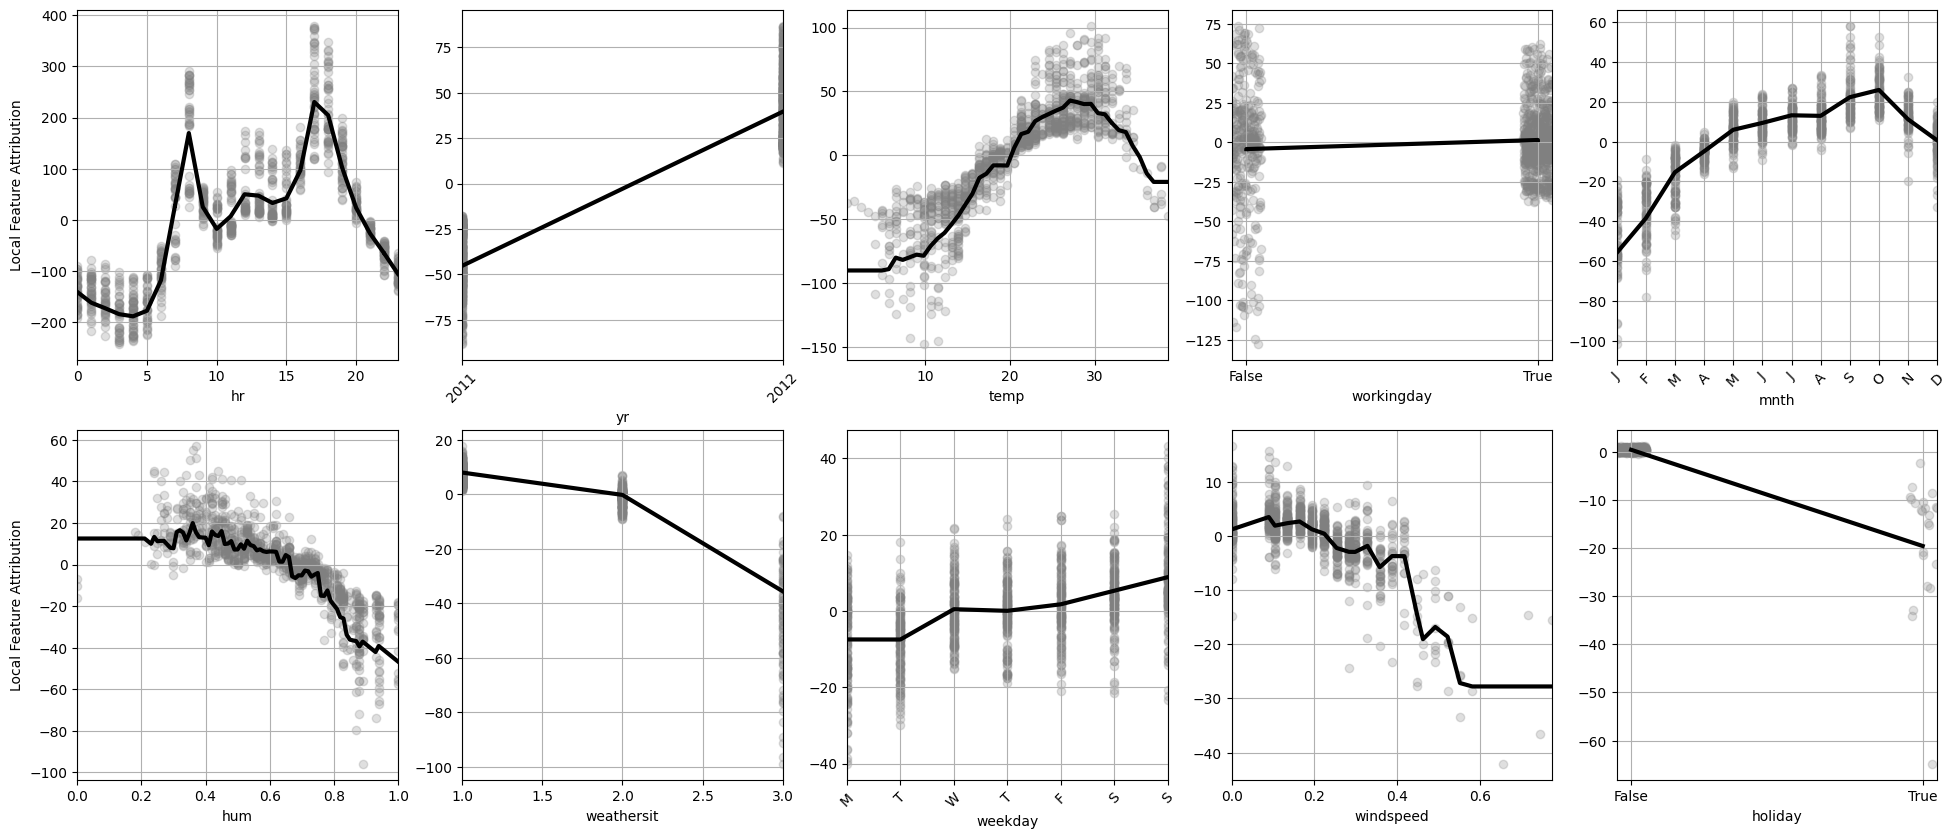

In [16]:
from pyfd.plots import attrib_scatter_plot

# We plot the h_i terms along side the Shapley Values
attrib_scatter_plot(decomposition, shap_values, background, features, n_cols=5, normalize_y=False, figsize=(24, 10))

In this scatter plot, the dark lines are the $h_i$ terms of the decomposition (also called Partial Dependence Plots or PDP for short).
The grey dots are the Shapley Values. We observe great disagreements between the PDP and SHAP values of the `hr`, `yr`, `temp`, and `workingday` features. In the case of `workinday`, the disagreements are so large that it is hard to claim whether being a workingday increases of decreases the number of bike rentals compared to a non-workinday.

These local feature importance scores (Functional Decompositions and SHAP) can be aggregated to yield global feature importance.

Text(0.5, 23.52222222222222, 'Global Feature Importance')

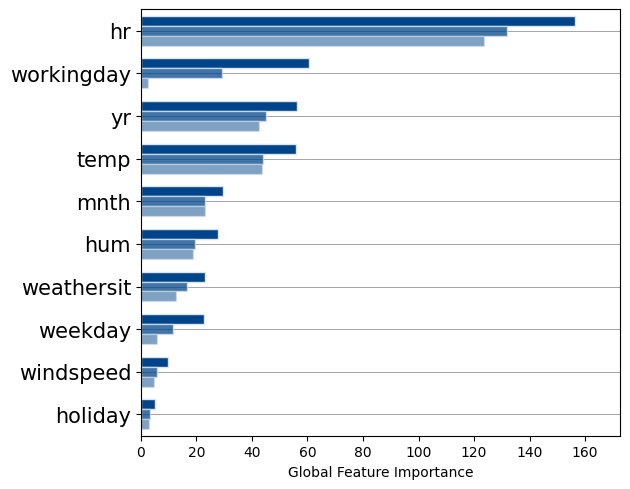

In [17]:
from pyfd.decompositions import get_PDP_PFI_importance
from pyfd.shapley import get_SHAP_importance
from pyfd.plots import bar

I_PDP, I_PFI = get_PDP_PFI_importance(decomposition)
I_SHAP = get_SHAP_importance(shap_values)
bar([I_PFI, I_SHAP, I_PDP], features.names())
plt.xlabel("Global Feature Importance")

There are strong disagreements between the three methods regarding the importance of the
feature `workingday`: PDP gives it no importance, SHAP ranks it fourth, and PFI ranks it second.

## Increasing Explanations Alignment

Given the disagreements on the local/global importance of features such as `workingday`, it 
is difficult to make trustworthy claims about the model behavior. The motto behind `PyFD` is to increase alignment 
between explainability methods by reducing features interactions. Like previously, we measure the strength of interactions with the `get_CoE` function.

In [18]:
from pyfd.decompositions import get_CoE

print(get_CoE(decomposition))

29.930611601103095


With tree-based models, we can go a step further and quantify which pairs of features are involved in interactions.

In [ ]:
from pyfd.shapley import taylor_treeshap
from pyfd.plots import interactions_heatmap

# This implementation uses the `recurse` algorithm which needs # a small background
small_background = X_train[:500]
Phis = taylor_treeshap(model, small_background, small_background, features)

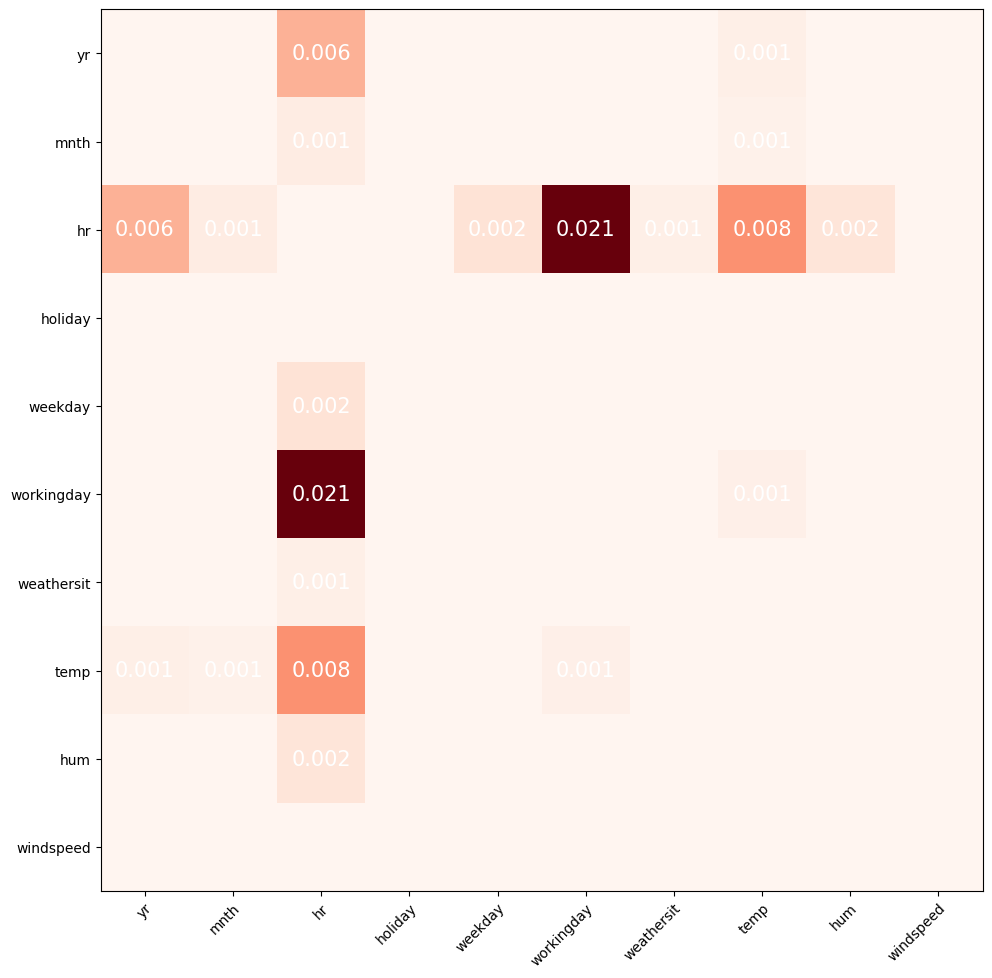

In [20]:
interactions_heatmap(Phis, features.names())

The model contains strong interactions between `hr-workingday`, `hr-temp`, and `hr-yr`.
We do not advocate reducing these interactions with feature grouping. The reason being that `hr` interacts 
with three different features, so we would need to group `hr-workingday-temp-yr`.
Interpreting such a large group might be difficult. We instead recommend reducing these interactions 
by fitting a FD-Tree using only the features `yr`, `hr`, `workingday` as the split candidates.
The reason we do not split w.r.t `temp` is subjective.

In [21]:
from pyfd.fd_trees import CoE_Tree

# Fit a FDTree by passing the `decomposition` as argument.
interacting_features = [0, 2, 5]
tree = CoE_Tree(max_depth=2, features=features.select(interacting_features), alpha=0.02)
tree.fit(background[:, interacting_features], decomposition)
tree.print(verbose=True)

LoA 0.2993
Samples 1000
If workingday ≤ 0.0000:
|   LoA 0.0491
|   Samples 328
|   If hr ≤ 7.0000:
|   |   LoA 0.0013
|   |   Samples 105
|   |   Region 0
|   else:
|   |   LoA 0.0230
|   |   Samples 223
|   |   Region 1
else:
|   LoA 0.1050
|   Samples 672
|   If hr ≤ 6.0000:
|   |   LoA 0.0011
|   |   Samples 190
|   |   Region 2
|   else:
|   |   LoA 0.0629
|   |   Samples 482
|   |   Region 3
Final LoA 0.0883


The FD-Tree is able to reduce the CoE (here called LoA) from 29% to about 9% by separating workingdays from non-workindays and
early hours from day-time hours. This fitted tree can then be used to assign data points to their region.

In [22]:
# Using regional backgrounds
regions = tree.predict(background[:, interacting_features])
print(regions[:10])
rules = tree.rules()
print(rules)

[3 2 3 0 0 3 1 3 2 3]
{0: '(not workingday & hr<=7.00)', 1: '(not workingday & hr>7.00)', 2: '(workingday & hr<=6.00)', 3: '(workingday & hr>6.00)'}


In [ ]:
# We compute regional decompositions and Shapley values
regional_backgrounds = [[], [], [], []]
regional_decomposition = [[], [], [], []]
regional_shap = [[], [], [], []]
for r in range(4):
    regional_backgrounds[r] = background[regions==r]
    # Regional Decomposition
    regional_decomposition[r] = get_components_tree(model,
                                                    regional_backgrounds[r],
                                                    regional_backgrounds[r],
                                                    features,
                                                    anchored=True)
    # Shapley values
    regional_shap[r] = interventional_treeshap(model,
                                               regional_backgrounds[r],
                                               regional_backgrounds[r],
                                               features)

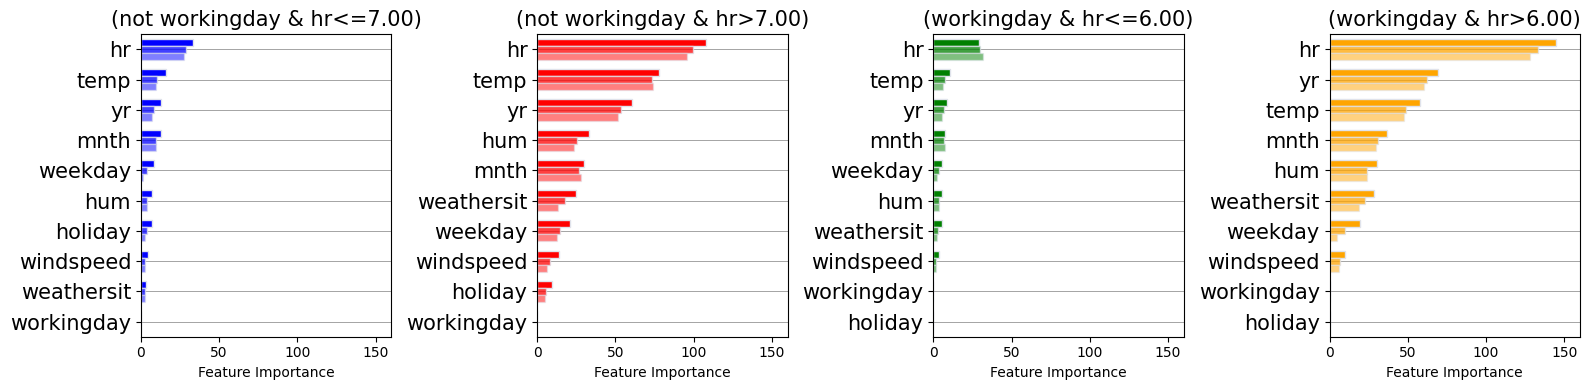

In [25]:
from pyfd.plots import COLORS

fig, axes = plt.subplots(1, 4, figsize=(16, 4))
for r in range(4):
    I_PDP, I_PFI = get_PDP_PFI_importance(regional_decomposition[r])
    I_SHAP = get_SHAP_importance(regional_shap[r])
    bar([I_PFI, I_SHAP, I_PDP], features.names(), ax=axes[r], color=COLORS[r])
    axes[r].set_xlim(0, 160)
    axes[r].set_xlabel("Feature Importance")
    axes[r].set_title(rules[r], fontsize=15)

Our first observation is that the PDP/SHAP/PFI feature importance are almost in perfect agreement, which is a consequence of
minimizing feature interactions with FD-Trees. 

Secondly, the feature `workingday` is no longer given any importance by the three methods. This does not mean that `workingday` 
is not an important feature! Rather, assigning a score to this feature is ill-posed because it interacts strongly with others. 
According to the FD-Tree, it is better to interpret workinday as a feature that affects the behavior of others. 

Thirdly, all features have a reduced importance when restricted to early-time hours (blue and green bars). This suggests 
that the model has less variability within these regions, which is confirmed by plotting the $h_i$ terms and Shapley Values within each region. 

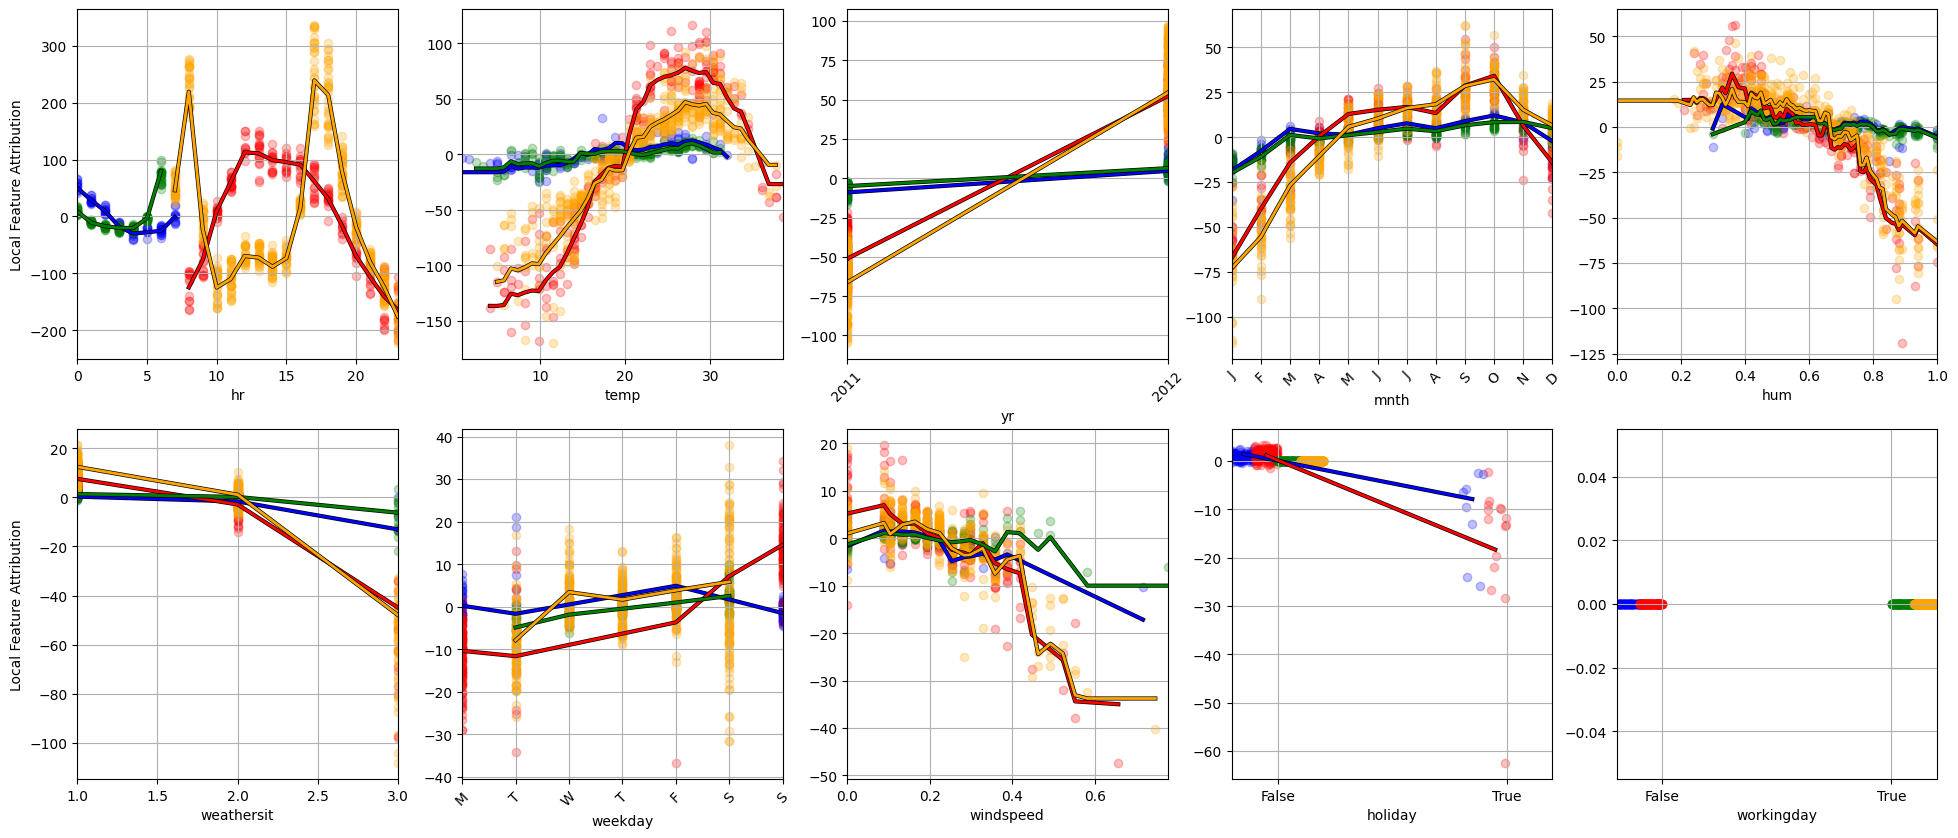

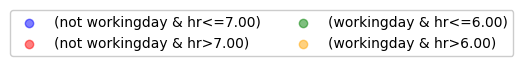

In [26]:
from pyfd.plots import plot_legend

# Regional h_i and SHAP values
attrib_scatter_plot(regional_decomposition, regional_shap, regional_backgrounds, features, normalize_y=False, figsize=(24, 10))
plot_legend(rules, ncol=2)

This plot contains many interesting patterns. 

First, the PDP/SHAP local attributions of `hr` depend on whether it is a working day or not. On workingdays, the local attributions of
`hr` peaks at rush hours, while they peak in the afternoon on non-workingdays. This could imply that bikes are mostly rented 
for work-related purposes on working days, while they are rented for recreational purposes during non-workingdays.

Second, the PDPs of features `temp`, `yr`, `mnth`, `hum`, and `weathersit` are flat whenever the region is restricted to 
early-time hours (i.e. the blue and green curves). Additionally, the Shapley Values are very small in both green and 
blue regions. This implies that these features have little effect on the model response whenever it is early in the morning. 
In the case of `temp`, the PDP local attribution is non-flat in the yellow and red regions. This suggests that increasing 
temperature increases the model output, on average. This effect is more pronounced on non-workingday (red) compared to a 
workingday (yellow). Note that such behavior is a three-way interaction : the effect of `temp` on the model response
depends on both the `hr` and `workingday`. 

Third, the local attributions of `holiday` present some peculiar behaviors. Whenever it is a working day, the feature 
has no attribution because it does not vary (it is stuck at `holiday=False`). However, since non-workingdays can be 
holidays or not, the feature does have an effect on the model in the blue and red regions. In the case of the red region
(non-workingdays during daytime hours), the attribution of `holiday=True` is negative, meaning that there are less bike 
rentals on holidays compared to non-holidays.
